# 🔴 Sistema de Detección de Oportunidades de SHORT

Sistema completo para mercados bajistas de criptomonedas.

## 📦 Instalación de Dependencias

In [1]:
# Ejecutar solo la primera vez
!pip install ccxt pandas ta matplotlib plotly numpy seaborn nbformat ipywidgets -q
print('✅ Instalación completada')

✅ Instalación completada


## 📚 Imports

In [2]:
import ccxt
import pandas as pd
import numpy as np
import ta
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.dates import DateFormatter
import seaborn as sns

# Intentar importar plotly
try:
    import plotly.graph_objects as go
    from plotly.subplots import make_subplots
    PLOTLY_AVAILABLE = True
    print('✅ Plotly disponible')
except:
    PLOTLY_AVAILABLE = False
    print('⚠️ Plotly no disponible, usando Matplotlib')

pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
plt.style.use('dark_background')
sns.set_palette('husl')

print('✅ Librerías cargadas correctamente')

✅ Plotly disponible
✅ Librerías cargadas correctamente


## 🔌 Configuración del Exchange

In [3]:
exchange = ccxt.binance({
    'enableRateLimit': True,
    'options': {'defaultType': 'future'}
})

markets = exchange.load_markets()
print(f'✅ Conectado a Binance - {len(markets)} mercados')

SYMBOLS = [
    'BTC/USDT', 'ETH/USDT', 'BNB/USDT', 'XRP/USDT', 'ADA/USDT',
    'SOL/USDT', 'DOGE/USDT', 'MATIC/USDT', 'DOT/USDT', 'AVAX/USDT',
    'LINK/USDT', 'UNI/USDT', 'ATOM/USDT', 'LTC/USDT', 'ETC/USDT'
]

TIMEFRAME = '1h'
LIMIT = 200

print(f'📊 Analizando {len(SYMBOLS)} símbolos en {TIMEFRAME}')

✅ Conectado a Binance - 4226 mercados
📊 Analizando 15 símbolos en 1h


## 📊 Obtención de Datos

In [4]:
def get_ohlcv_data(symbol, timeframe=TIMEFRAME, limit=LIMIT):
    try:
        ohlcv = exchange.fetch_ohlcv(symbol, timeframe, limit=limit)
        df = pd.DataFrame(ohlcv, columns=['timestamp', 'open', 'high', 'low', 'close', 'volume'])
        df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
        df.set_index('timestamp', inplace=True)
        return df
    except Exception as e:
        print(f'❌ Error {symbol}: {e}')
        return None

def get_funding_rate(symbol):
    try:
        ticker = symbol.replace('/USDT', 'USDT')
        funding = exchange.fapiPublicGetPremiumIndex({'symbol': ticker})
        return float(funding['lastFundingRate']) * 100
    except:
        return None

# Test
df_test = get_ohlcv_data('BTC/USDT')
if df_test is not None:
    print(f'✅ {len(df_test)} velas obtenidas')
    display(df_test.tail(3))

✅ 200 velas obtenidas


,open,high,low,close,volume
timestamp,,,,,
2026-02-10 17:00:00,69473.5,69957.9,69267.8,69886.6,8006.235
2026-02-10 18:00:00,69886.5,69910.1,68555.6,68860.0,10012.650
2026-02-10 19:00:00,68860.0,69273.4,68658.9,69264.1,4992.719


## 📈 Indicadores Técnicos

In [5]:
def calculate_indicators(df):
    df = df.copy()
    
    # RSI
    df['rsi'] = ta.momentum.rsi(df['close'], window=14)
    
    # MACD
    macd = ta.trend.MACD(df['close'])
    df['macd'] = macd.macd()
    df['macd_signal'] = macd.macd_signal()
    df['macd_hist'] = macd.macd_diff()
    
    # EMAs
    df['ema_9'] = ta.trend.ema_indicator(df['close'], window=9)
    df['ema_20'] = ta.trend.ema_indicator(df['close'], window=20)
    df['ema_50'] = ta.trend.ema_indicator(df['close'], window=50)
    df['ema_200'] = ta.trend.ema_indicator(df['close'], window=200)
    
    # Bollinger
    bollinger = ta.volatility.BollingerBands(df['close'], window=20)
    df['bb_high'] = bollinger.bollinger_hband()
    df['bb_mid'] = bollinger.bollinger_mavg()
    df['bb_low'] = bollinger.bollinger_lband()
    
    # Volumen
    df['volume_sma'] = df['volume'].rolling(window=20).mean()
    df['volume_ratio'] = df['volume'] / df['volume_sma']
    
    # Stochastic
    stoch = ta.momentum.StochasticOscillator(df['high'], df['low'], df['close'])
    df['stoch_k'] = stoch.stoch()
    
    # ADX
    df['adx'] = ta.trend.adx(df['high'], df['low'], df['close'])
    
    # Cambio %
    df['pct_change'] = df['close'].pct_change() * 100
    
    return df

# Test
if df_test is not None:
    df_ind = calculate_indicators(df_test)
    print('✅ Indicadores calculados')
    display(df_ind[['close', 'rsi', 'macd', 'ema_20']].tail())

✅ Indicadores calculados


,close,rsi,macd,ema_20
timestamp,,,,
2026-02-10 15:00:00,69251.5,48.403346,-339.825108,69266.904527
2026-02-10 16:00:00,69473.5,50.676072,-280.762120,69286.580286
2026-02-10 17:00:00,69886.6,54.676750,-198.334284,69343.725021
2026-02-10 18:00:00,68860.0,44.924775,-213.387868,69297.655971
2026-02-10 19:00:00,69264.1,48.796146,-190.514318,69294.460165


## 🎯 Sistema de Scoring

In [6]:
def analyze_short_signals(df, symbol):
    last = df.iloc[-1]
    prev = df.iloc[-2]
    
    signals = []
    score = 0
    details = {}
    
    # RSI (0-3 puntos)
    if last['rsi'] > 75:
        signals.append('🔴 RSI muy sobrecomprado (>75)')
        score += 3
    elif last['rsi'] > 70:
        signals.append('🟡 RSI sobrecomprado (>70)')
        score += 2
    elif last['rsi'] > 65:
        signals.append('🟢 RSI alto (>65)')
        score += 1
    details['rsi'] = last['rsi']
    
    # MACD (0-4 puntos)
    if prev['macd_hist'] > 0 and last['macd_hist'] < 0:
        signals.append('🔴 MACD cruce bajista RECIENTE')
        score += 4
    elif last['macd_hist'] < 0:
        signals.append('🟡 MACD zona bajista')
        score += 2
    details['macd_signal'] = 'Bajista' if last['macd_hist'] < 0 else 'Alcista'
    
    # EMAs (0-3 puntos)
    below_emas = sum([
        last['close'] < last['ema_20'],
        last['close'] < last['ema_50'],
        last['close'] < last['ema_200']
    ])
    if below_emas == 3:
        signals.append('🔴 Precio bajo TODAS las EMAs')
        score += 3
    elif below_emas == 2:
        signals.append('🟡 Precio bajo 2 EMAs')
        score += 2
    elif below_emas == 1:
        score += 1
    details['below_emas'] = f'{below_emas}/3'
    
    # Death Cross (0-5 puntos)
    if prev['ema_50'] >= prev['ema_200'] and last['ema_50'] < last['ema_200']:
        signals.append('💀 DEATH CROSS detectado')
        score += 5
    elif last['ema_50'] < last['ema_200']:
        score += 1
    
    # Stochastic (0-2 puntos)
    if last['stoch_k'] > 80:
        signals.append('🟡 Stochastic sobrecomprado')
        score += 2
    details['stochastic'] = last['stoch_k']
    
    # Volumen (0-3 puntos)
    if last['close'] < last['open'] and last['volume_ratio'] > 2:
        signals.append('🔴 ALTO volumen bajista')
        score += 3
    elif last['close'] < last['open'] and last['volume_ratio'] > 1.5:
        signals.append('🟡 Volumen elevado bajista')
        score += 2
    details['volume_ratio'] = last['volume_ratio']
    
    # Bollinger (0-2 puntos)
    if last['close'] > last['bb_high'] * 0.99:
        signals.append('🟡 Precio en banda superior')
        score += 2
    
    # ADX (0-2 puntos)
    if last['adx'] > 25 and last['close'] < last['ema_20']:
        signals.append('🟢 Tendencia bajista fuerte')
        score += 2
    details['adx'] = last['adx']
    
    # Cambio reciente
    recent_change = df['pct_change'].tail(5).sum()
    if recent_change < -3:
        signals.append(f'🔴 Caída reciente: {recent_change:.1f}%')
        score += 1
    details['5_candles_change'] = recent_change
    
    # Funding rate
    funding = get_funding_rate(symbol)
    if funding:
        details['funding_rate'] = funding
        if funding < -0.01:
            signals.append(f'💰 Funding negativo: {funding:.3f}%')
            score += 1
    
    return {
        'symbol': symbol,
        'score': score,
        'signals': signals,
        'price': last['close'],
        'details': details,
        'timestamp': datetime.now()
    }

# Test
if df_test is not None:
    df_test_ind = calculate_indicators(df_test)
    analysis = analyze_short_signals(df_test_ind, 'BTC/USDT')
    print(f"Score: {analysis['score']}/25")
    for signal in analysis['signals']:
        print(f'  {signal}')

Score: 4/25
  🔴 Precio bajo TODAS las EMAs


## 🔍 Función Principal de Escaneo

In [7]:
def scan_all_markets(symbols=SYMBOLS, min_score=8):
    results = []
    
    print(f'🔍 Escaneando {len(symbols)} criptomonedas...')
    print('=' * 80)
    
    for i, symbol in enumerate(symbols, 1):
        try:
            df = get_ohlcv_data(symbol)
            if df is None or len(df) < 200:
                continue
            
            df = calculate_indicators(df)
            analysis = analyze_short_signals(df, symbol)
            results.append(analysis)
            
            if analysis['score'] >= min_score:
                print(f"✅ {i}/{len(symbols)} - {symbol}: Score {analysis['score']}/25 ⭐")
            else:
                print(f"⚪ {i}/{len(symbols)} - {symbol}: Score {analysis['score']}/25")
                
        except Exception as e:
            print(f"❌ {i}/{len(symbols)} - Error en {symbol}: {str(e)[:50]}")
            continue
    
    results.sort(key=lambda x: x['score'], reverse=True)
    opportunities = [r for r in results if r['score'] >= min_score]
    
    print('\n' + '=' * 80)
    print(f'🎯 Encontradas {len(opportunities)} oportunidades con score >= {min_score}')
    
    return results, opportunities

print('✅ Función scan_all_markets definida')

✅ Función scan_all_markets definida


## 🚀 Ejecutar Escaneo

In [8]:
print('🔍 Ejecutando escaneo...\n')

all_results, opportunities = scan_all_markets(min_score=8)

print('\n' + '='*100)
print('📊 RESUMEN POR NIVELES:')
print('='*100)

levels = [
    (15, '🔴 MUY ALTO'),
    (12, '🟠 ALTO'),
    (10, '🟡 MEDIO'),
    (8, '🟢 MODERADO'),
    (6, '🔵 BAJO')
]

for min_score, label in levels:
    count = len([r for r in all_results if r['score'] >= min_score])
    print(f'{label} (>={min_score:2d}): {count:2d} oportunidades')

if not opportunities and all_results:
    opportunities = all_results[:5]
    print(f'\n⚠️ Tomando top 5 (scores bajos en mercado)')

🔍 Ejecutando escaneo...

🔍 Escaneando 15 criptomonedas...
⚪ 1/15 - BTC/USDT: Score 4/25
⚪ 2/15 - ETH/USDT: Score 5/25
✅ 3/15 - BNB/USDT: Score 8/25 ⭐
⚪ 4/15 - XRP/USDT: Score 7/25
⚪ 5/15 - ADA/USDT: Score 6/25
⚪ 6/15 - SOL/USDT: Score 6/25
⚪ 7/15 - DOGE/USDT: Score 6/25
❌ Error MATIC/USDT: binance does not have market symbol MATIC/USDT
⚪ 9/15 - DOT/USDT: Score 6/25
⚪ 10/15 - AVAX/USDT: Score 6/25
⚪ 11/15 - LINK/USDT: Score 4/25
⚪ 12/15 - UNI/USDT: Score 4/25
⚪ 13/15 - ATOM/USDT: Score 4/25
⚪ 14/15 - LTC/USDT: Score 4/25
⚪ 15/15 - ETC/USDT: Score 6/25

🎯 Encontradas 1 oportunidades con score >= 8

📊 RESUMEN POR NIVELES:
🔴 MUY ALTO (>=15):  0 oportunidades
🟠 ALTO (>=12):  0 oportunidades
🟡 MEDIO (>=10):  0 oportunidades
🟢 MODERADO (>= 8):  1 oportunidades
🔵 BAJO (>= 6):  8 oportunidades


## 📊 Tabla de Resultados

In [9]:
if opportunities:
    print('\n🎯 TOP OPORTUNIDADES DE SHORT')
    print('=' * 100)
    
    data = []
    for opp in opportunities:
        data.append({
            'Symbol': opp['symbol'],
            'Score': opp['score'],
            'Precio': f"${opp['price']:.4f}",
            'RSI': f"{opp['details'].get('rsi', 0):.1f}",
            'MACD': opp['details'].get('macd_signal', '-'),
            'EMAs': opp['details'].get('below_emas', '-'),
            'Vol': f"{opp['details'].get('volume_ratio', 0):.2f}x",
            'ADX': f"{opp['details'].get('adx', 0):.1f}",
            'Funding': f"{opp['details'].get('funding_rate', 0):.3f}%",
            'Señales': len(opp['signals'])
        })
    
    df_opportunities = pd.DataFrame(data)
    display(df_opportunities)
    
    print('\n\n📋 DETALLES TOP 5:')
    print('=' * 100)
    for i, opp in enumerate(opportunities[:5], 1):
        print(f'\n{i}. {opp["symbol"]} - Score: {opp["score"]}/25 ⭐')
        print(f'   💰 Precio: ${opp["price"]:.6f}')
        print(f'   📊 RSI: {opp["details"].get("rsi", 0):.1f}')
        print(f'   🔄 Funding: {opp["details"].get("funding_rate", 0):.4f}%')
        print(f'   🎯 Señales ({len(opp["signals"])}):')
        for signal in opp['signals']:
            print(f'      • {signal}')
else:
    print('⚠️ No hay oportunidades con el score mínimo')


🎯 TOP OPORTUNIDADES DE SHORT


,Symbol,Score,Precio,RSI,MACD,EMAs,Vol,ADX,Funding,Señales
0,BNB/USDT,8,$618.4800,38.6,Bajista,3/3,0.71x,33.3,0.000%,3




📋 DETALLES TOP 5:

1. BNB/USDT - Score: 8/25 ⭐
   💰 Precio: $618.480000
   📊 RSI: 38.6
   🔄 Funding: 0.0000%
   🎯 Señales (3):
      • 🟡 MACD zona bajista
      • 🔴 Precio bajo TODAS las EMAs
      • 🟢 Tendencia bajista fuerte


## 📈 Visualización con Matplotlib

📊 Graficando mejor oportunidad: BNB/USDT


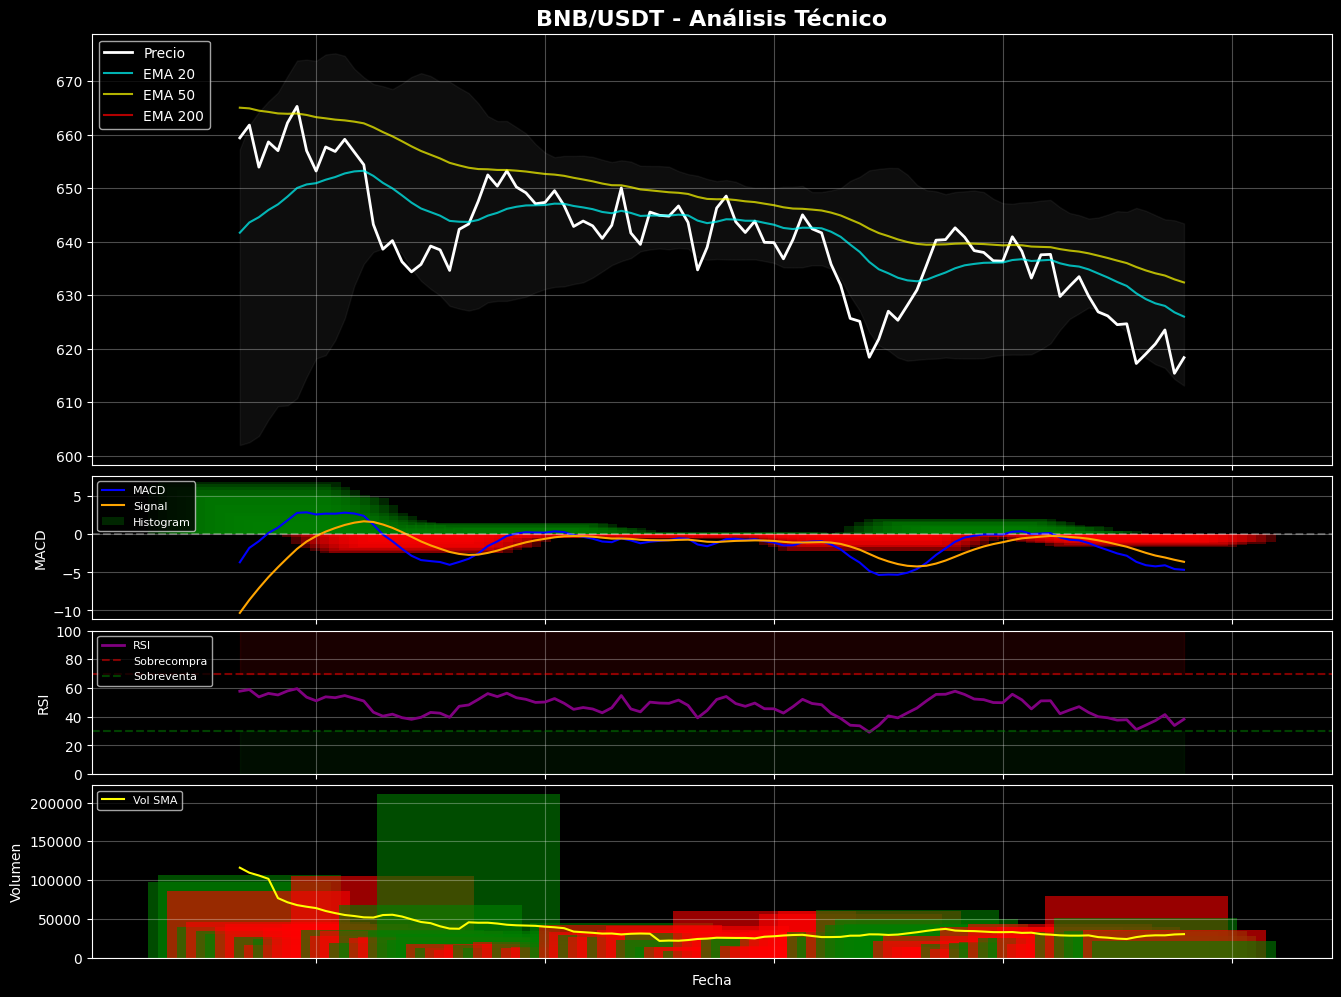

In [10]:
def plot_crypto_matplotlib(symbol, df=None):
    """Gráfico completo usando solo Matplotlib"""
    
    if df is None:
        df = get_ohlcv_data(symbol)
        df = calculate_indicators(df)
    
    df_plot = df.tail(100).copy()
    
    # Crear figura
    fig = plt.figure(figsize=(16, 12))
    gs = gridspec.GridSpec(4, 1, height_ratios=[3, 1, 1, 1.2], hspace=0.05)
    
    # 1. Precio y EMAs
    ax1 = plt.subplot(gs[0])
    ax1.plot(df_plot.index, df_plot['close'], label='Precio', color='white', linewidth=2)
    ax1.plot(df_plot.index, df_plot['ema_20'], label='EMA 20', color='cyan', alpha=0.7)
    ax1.plot(df_plot.index, df_plot['ema_50'], label='EMA 50', color='yellow', alpha=0.7)
    ax1.plot(df_plot.index, df_plot['ema_200'], label='EMA 200', color='red', alpha=0.7)
    ax1.fill_between(df_plot.index, df_plot['bb_low'], df_plot['bb_high'], alpha=0.1, color='gray')
    ax1.set_title(f'{symbol} - Análisis Técnico', fontsize=16, fontweight='bold')
    ax1.legend(loc='upper left')
    ax1.grid(alpha=0.3)
    ax1.set_xticklabels([])
    
    # 2. MACD
    ax2 = plt.subplot(gs[1], sharex=ax1)
    ax2.plot(df_plot.index, df_plot['macd'], label='MACD', color='blue', linewidth=1.5)
    ax2.plot(df_plot.index, df_plot['macd_signal'], label='Signal', color='orange', linewidth=1.5)
    colors = ['green' if x > 0 else 'red' for x in df_plot['macd_hist']]
    ax2.bar(df_plot.index, df_plot['macd_hist'], color=colors, alpha=0.3, label='Histogram')
    ax2.axhline(y=0, color='white', linestyle='--', alpha=0.3)
    ax2.legend(loc='upper left', fontsize=8)
    ax2.grid(alpha=0.3)
    ax2.set_ylabel('MACD')
    ax2.set_xticklabels([])
    
    # 3. RSI
    ax3 = plt.subplot(gs[2], sharex=ax1)
    ax3.plot(df_plot.index, df_plot['rsi'], label='RSI', color='purple', linewidth=2)
    ax3.axhline(y=70, color='red', linestyle='--', alpha=0.5, label='Sobrecompra')
    ax3.axhline(y=30, color='green', linestyle='--', alpha=0.5, label='Sobreventa')
    ax3.fill_between(df_plot.index, 70, 100, alpha=0.1, color='red')
    ax3.fill_between(df_plot.index, 0, 30, alpha=0.1, color='green')
    ax3.set_ylim(0, 100)
    ax3.legend(loc='upper left', fontsize=8)
    ax3.grid(alpha=0.3)
    ax3.set_ylabel('RSI')
    ax3.set_xticklabels([])
    
    # 4. Volumen
    ax4 = plt.subplot(gs[3], sharex=ax1)
    colors = ['red' if close < open_ else 'green' 
              for close, open_ in zip(df_plot['close'], df_plot['open'])]
    ax4.bar(df_plot.index, df_plot['volume'], color=colors, alpha=0.6)
    ax4.plot(df_plot.index, df_plot['volume_sma'], color='yellow', linewidth=1.5, label='Vol SMA')
    ax4.legend(loc='upper left', fontsize=8)
    ax4.grid(alpha=0.3)
    ax4.set_ylabel('Volumen')
    ax4.set_xlabel('Fecha')
    
    plt.tight_layout()
    plt.show()

# Graficar mejor oportunidad
if opportunities:
    best = opportunities[0]['symbol']
    print(f'📊 Graficando mejor oportunidad: {best}')
    plot_crypto_matplotlib(best)
else:
    print('⚠️ No hay oportunidades para graficar')

## 📊 Dashboard Múltiple

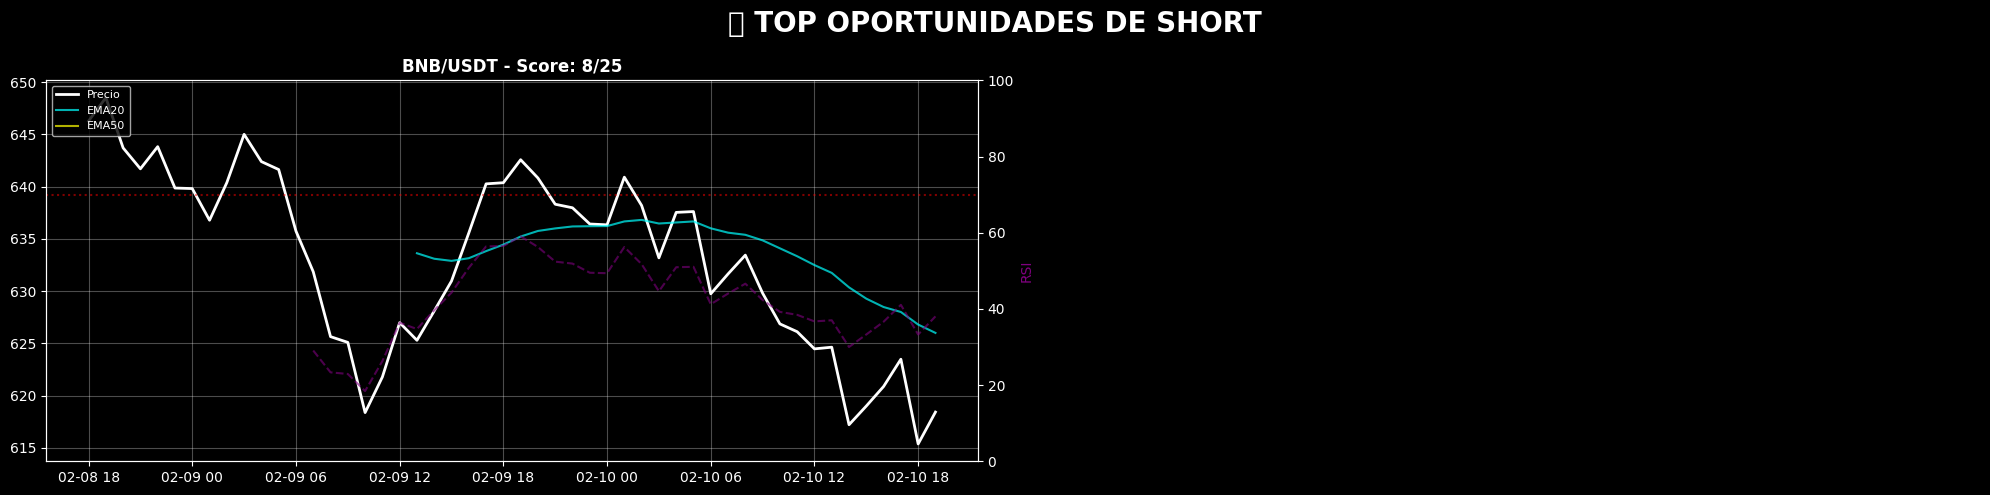

In [11]:
def plot_dashboard(opportunities, top_n=6):
    if len(opportunities) < 1:
        print('⚠️ No hay oportunidades para graficar')
        return
    
    top_n = min(top_n, len(opportunities))
    top_opps = opportunities[:top_n]
    
    rows = (top_n + 1) // 2
    fig, axes = plt.subplots(rows, 2, figsize=(20, 5*rows))
    fig.suptitle('🔴 TOP OPORTUNIDADES DE SHORT', fontsize=20, fontweight='bold')
    
    if rows == 1:
        axes = axes.reshape(1, -1)
    
    axes = axes.ravel()
    
    for idx, opp in enumerate(top_opps):
        symbol = opp['symbol']
        df = get_ohlcv_data(symbol, limit=50)
        df = calculate_indicators(df)
        
        ax = axes[idx]
        ax.plot(df.index, df['close'], label='Precio', color='white', linewidth=2)
        ax.plot(df.index, df['ema_20'], label='EMA20', color='cyan', alpha=0.7)
        ax.plot(df.index, df['ema_50'], label='EMA50', color='yellow', alpha=0.7)
        
        ax2 = ax.twinx()
        ax2.plot(df.index, df['rsi'], label='RSI', color='purple', linestyle='--', alpha=0.6)
        ax2.axhline(y=70, color='r', linestyle=':', alpha=0.5)
        ax2.set_ylim(0, 100)
        ax2.set_ylabel('RSI', color='purple')
        
        ax.set_title(f'{symbol} - Score: {opp["score"]}/25', fontsize=12, fontweight='bold')
        ax.legend(loc='upper left', fontsize=8)
        ax.grid(alpha=0.3)
    
    # Ocultar ejes vacíos
    for idx in range(len(top_opps), len(axes)):
        axes[idx].axis('off')
    
    plt.tight_layout()
    plt.show()

# Crear dashboard
if opportunities:
    plot_dashboard(opportunities, top_n=6)

## 📊 Estadísticas del Mercado

🔍 ESTADÍSTICAS DEL MERCADO
Score Máximo:   8/25
Score Promedio: 5.4/25
Score Mediano:  6.0/25
Score Mínimo:   4/25


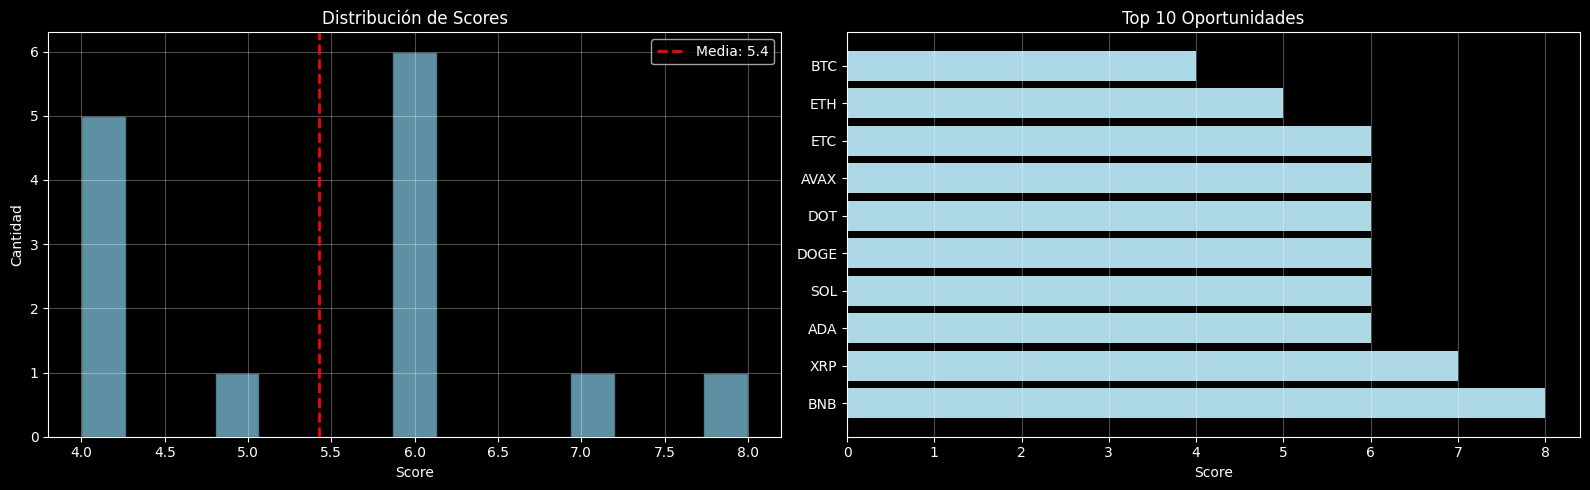


💡 INTERPRETACIÓN:
   ⚠️ Mercado con pocas señales bajistas fuertes
   💡 Posiblemente no está en fase bajista clara


In [12]:
if all_results:
    scores = [r['score'] for r in all_results]
    
    print('🔍 ESTADÍSTICAS DEL MERCADO')
    print('='*80)
    print(f'Score Máximo:   {max(scores)}/25')
    print(f'Score Promedio: {np.mean(scores):.1f}/25')
    print(f'Score Mediano:  {np.median(scores):.1f}/25')
    print(f'Score Mínimo:   {min(scores)}/25')
    
    # Histograma
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))
    
    ax1.hist(scores, bins=15, color='skyblue', edgecolor='black', alpha=0.7)
    ax1.axvline(np.mean(scores), color='red', linestyle='--', linewidth=2, 
                label=f'Media: {np.mean(scores):.1f}')
    ax1.set_xlabel('Score')
    ax1.set_ylabel('Cantidad')
    ax1.set_title('Distribución de Scores')
    ax1.legend()
    ax1.grid(alpha=0.3)
    
    # Top 10
    top_10 = all_results[:10]
    symbols = [r['symbol'].replace('/USDT', '') for r in top_10]
    scores_10 = [r['score'] for r in top_10]
    
    colors = ['darkred' if s >= 15 else 'orange' if s >= 12 else 'yellow' if s >= 10 else 'lightblue' 
              for s in scores_10]
    bars = ax2.barh(symbols, scores_10, color=colors)
    ax2.set_xlabel('Score')
    ax2.set_title('Top 10 Oportunidades')
    ax2.grid(axis='x', alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Interpretación
    print(f'\n💡 INTERPRETACIÓN:')
    if max(scores) < 10:
        print('   ⚠️ Mercado con pocas señales bajistas fuertes')
        print('   💡 Posiblemente no está en fase bajista clara')
    elif max(scores) < 15:
        print('   🟡 Señales bajistas moderadas')
        print('   💡 Hay oportunidades pero requieren confirmación')
    else:
        print('   🔴 Señales bajistas fuertes detectadas')
        print('   💡 Buenas oportunidades de short en el mercado')
else:
    print('❌ No hay resultados para analizar')

## 💾 Exportar Resultados

In [13]:
if opportunities:
    timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
    filename = f'short_opportunities_{timestamp}.csv'
    
    df_opportunities.to_csv(filename, index=False)
    print(f'✅ Resultados exportados: {filename}')
    
    print(f'\n📊 RESUMEN FINAL:')
    print(f'   • Criptos analizadas: {len(all_results)}')
    print(f'   • Oportunidades encontradas: {len(opportunities)}')
    print(f'   • Score promedio: {np.mean([r["score"] for r in all_results]):.1f}/25')
    print(f'   • Mejor oportunidad: {opportunities[0]["symbol"]} ({opportunities[0]["score"]}/25)')
else:
    print('⚠️ No hay oportunidades para exportar')

✅ Resultados exportados: short_opportunities_20260210_204940.csv

📊 RESUMEN FINAL:
   • Criptos analizadas: 14
   • Oportunidades encontradas: 1
   • Score promedio: 5.4/25
   • Mejor oportunidad: BNB/USDT (8/25)
